## Introduction

This project investigates community detection on Zachary’s Karate Club graph using **spectral modularity maximization**.  
Below, we import Python libraries required for:

- building the Karate graph,
- computing modularity matrices,
- performing spectral bisection,
- drawing graphs and communities,
- computing centrality metrics.

These imports must be loaded before running any subsequent code.


In [11]:
# Standard imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import deque, OrderedDict

# Inline plotting and figure defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)


## Load the Karate Club Graph

We load the classic Karate Club network using NetworkX.  
This graph has:
- 34 nodes (club members)
- 78 edges (friendship interactions)

We also generate a fixed spring layout (`spring_layout`) so that all visualizations remain consistent across iterations.


In [12]:
# Load Zachary's Karate Club (NetworkX builtin)
G = nx.karate_club_graph()
n = G.number_of_nodes()
m = G.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")

# Fix a spring layout (seed for reproducibility)
fixed_pos = nx.spring_layout(G, seed=42)


Nodes: 34, Edges: 78


## Modularity Matrix Construction

We define helper functions to compute the **global modularity matrix**:

\[
B = A - \frac{k k^\top}{2m}
\]

where:
- \(A\) = adjacency matrix,  
- \(k\) = node degree vector,  
- \(m\) = number of edges.

We also define a function to extract a **restricted block** \(B^{(C)}\) for a community \(C\).  
This block is needed during recursive bisection.


In [13]:
def modularity_matrix(G, node_list=None):
    """
    Return B, degrees, and 2m for graph G.
    If node_list is None, uses sorted(G.nodes()) ordering.
    """
    if node_list is None:
        node_list = sorted(G.nodes())
    A = nx.to_numpy_array(G, nodelist=node_list, dtype=float)
    degrees = np.array([G.degree(u) for u in node_list], dtype=float)
    two_m = 2.0 * G.number_of_edges()
    kmat = np.outer(degrees, degrees) / two_m
    B = A - kmat
    return B, degrees, two_m

def restricted_B(B_full, nodes, global_nodes):
    """
    Return the submatrix of B_full corresponding to `nodes`.
    global_nodes is the ordering used to build B_full.
    """
    idx = [global_nodes.index(v) for v in nodes]
    return B_full[np.ix_(idx, idx)]


## Leading Eigenpair & Bipartition Logic

According to the Rayleigh–Ritz theorem:
- The leading eigenvector of the modularity matrix indicates the direction that maximizes modularity.
- Nodes are split by the **sign** of the eigenvector entries:
  - positive → community 1  
  - negative → community 2  

We implement:
- A function to compute the **largest eigenvalue** and its eigenvector.
- A function to split nodes by sign.


In [14]:
def leading_eigenpair(B):
    """
    Return (largest_eigenvalue, corresponding_eigenvector).
    Use np.linalg.eigh for symmetric matrices.
    """
    vals, vecs = np.linalg.eigh(B)   # ascending order
    idx = np.argmax(vals)
    return float(vals[idx]), vecs[:, idx]

def split_by_leading(B_restricted, nodes):
    """
    Given restricted modularity matrix and node list, return:
    (lambda, eigenvector, plus_nodes, minus_nodes)
    where sign(eigenvector) > 0 => plus, <=0 => minus (treat 0 as +).
    """
    lam, vec = leading_eigenpair(B_restricted)
    signs = np.sign(vec)
    signs[signs == 0] = 1.0  # assign zeros to + group
    plus = [nodes[i] for i in range(len(nodes)) if signs[i] > 0]
    minus = [nodes[i] for i in range(len(nodes)) if signs[i] < 0]
    return lam, vec, plus, minus


## Recursive Spectral Bisection Algorithm

We now implement the full recursive community detection method:

1. Start with all nodes in one community.
2. Compute restricted modularity block \(B^{(C)}\).
3. Compute its leading eigenvalue:
   - If λ > 0 → splitting increases modularity → split the group.
   - If λ ≤ 0 → no split helps → stop for that group.
4. Recursively apply the same splitting procedure on each subgroup.

We also maintain a **history** list to track:
- which group was split,
- eigenvalues,
- resulting communities.


In [15]:
def recursive_bisection(G, B_full, global_nodes, max_communities=None):
    """
    Perform recursive spectral bisection using restricted modularity matrix.
    Returns final_communities (list of lists) and history (list of dicts per iteration).
    max_communities: optional cap to stop after reaching that many communities.
    """
    # Start with full node set
    initial = sorted(global_nodes)
    communities = [initial]
    queue = deque([initial])
    history = []
    iteration = 0

    while queue:
        group = queue.popleft()
        # optional stopping by number of communities
        if max_communities is not None and len(communities) >= max_communities:
            break

        # compute restricted B for this group
        Bc = restricted_B(B_full, group, global_nodes)
        lam, vec = leading_eigenpair(Bc)
        entry = {'iteration': iteration, 'group': list(group), 'lambda': lam}

        # stop-splitting condition
        if lam <= 0.0:
            entry['action'] = 'stop_no_split'
            history.append(entry)
            iteration += 1
            continue

        # split by sign of leading eigenvector
        signs = np.sign(vec)
        signs[signs == 0] = 1.0
        plus = [group[i] for i in range(len(group)) if signs[i] > 0]
        minus = [group[i] for i in range(len(group)) if signs[i] < 0]

        # guard: degenerate split (one side empty)
        if len(plus) == 0 or len(minus) == 0:
            entry['action'] = 'degenerate_no_split'
            history.append(entry)
            iteration += 1
            continue

        # commit split
        # remove the current group and add the two new groups
        # remove by matching set to avoid ordering issues
        for c in communities:
            if set(c) == set(group):
                communities.remove(c)
                break
        communities.append(sorted(plus))
        communities.append(sorted(minus))

        # enqueue both for further splitting
        queue.append(plus)
        queue.append(minus)

        entry.update({'action': 'split', 'plus': plus, 'minus': minus})
        history.append(entry)
        iteration += 1

    return communities, history


## Drawing Communities After Each Split

We define a plotting helper that visualizes the graph where:
- each community receives a unique color,
- nodes are labeled by ID,
- the layout remains fixed for visual clarity.

This helps us visually inspect how communities evolve after each iteration.


In [16]:
def draw_partition(G, communities, pos, ax=None, title=None):
    """
    Draw network G using given layout pos. communities is list of node lists.
    Node labels are node IDs. Colors are assigned per community.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    cmap = cm.get_cmap('tab20')  # up to 20 distinct colors
    color_map = {}
    for i, com in enumerate(communities):
        for n in com:
            color_map[n] = cmap(i % 20)
    node_colors = [color_map[n] for n in sorted(G.nodes())]
    nx.draw(G, pos, with_labels=True, labels={n: n for n in G.nodes()},
            node_color=node_colors, node_size=300, ax=ax)
    if title:
        ax.set_title(title)


## Node Metrics After Each Split

After every bisection iteration, we compute standard NetworkX node metrics:

- **Degree Centrality**: fraction of nodes directly connected  
- **Betweenness Centrality**: frequency of lying on shortest paths  
- **Closeness Centrality**: inverse of average distance to all other nodes  
- **Clustering Coefficient**: how tightly a node’s neighbors are connected  

We store these metrics in a dictionary indexed by iteration number.


In [17]:
def compute_metrics(G):
    """
    Compute degree centrality, betweenness, closeness, clustering for all nodes.
    Returns a dict of dictionaries keyed by metric name.
    """
    deg = nx.degree_centrality(G)
    btw = nx.betweenness_centrality(G)
    clo = nx.closeness_centrality(G)
    clust = nx.clustering(G)
    return {'degree': deg, 'betweenness': btw, 'closeness': clo, 'clustering': clust}

def run_and_track(G, max_communities=None):
    """
    Run recursive bisection on G and track metrics after each iteration.
    Returns:
      final_communities, history, metrics_over_iters, B_full, global_nodes
    metrics_over_iters is an OrderedDict mapping iteration_number -> metrics dict
    """
    global_nodes = sorted(G.nodes())
    B_full, degrees, two_m = modularity_matrix(G, node_list=global_nodes)
    final_communities, history = recursive_bisection(G, B_full, global_nodes, max_communities)
    metrics_over_iters = OrderedDict()
    iter_num = 0
    # baseline (iteration 0) before any split
    metrics_over_iters[iter_num] = compute_metrics(G)
    # For tracking evolution we record after each history entry (whether split or stop)
    for h in history:
        iter_num += 1
        metrics_over_iters[iter_num] = compute_metrics(G)
    return final_communities, history, metrics_over_iters, B_full, global_nodes


## Running the Algorithm and Tracking All Results

We now run:

1. The full recursive spectral modularity algorithm  
2. Track all:
   - communities,
   - eigenvalues,
   - bisection events,
   - centrality metrics per iteration.

Finally, we print the **final detected communities**.


In [18]:
# Run the algorithm (no max cap; change max_communities to enforce limit)
final_comms, history, metrics_over_iters, B_full, global_nodes = run_and_track(G, max_communities=None)

print(f'Final communities (count = {len(final_comms)}):')
for i, com in enumerate(final_comms, start=1):
    print(f'Community {i}:', sorted(com))


Final communities (count = 2):
Community 1: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community 2: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]


## Visualizing the Community Structure Across Iterations

Using the history generated earlier, we reconstruct how the community structure evolves:

- Iteration 0: all nodes together  
- Iteration 1: first spectral split  
- Further iterations: recursively splitting eligible communities  

Each panel shows the graph colored by its communities at that stage.


C:\Users\shrey\AppData\Local\Temp\ipykernel_12420\2747179469.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')  # up to 20 distinct colors


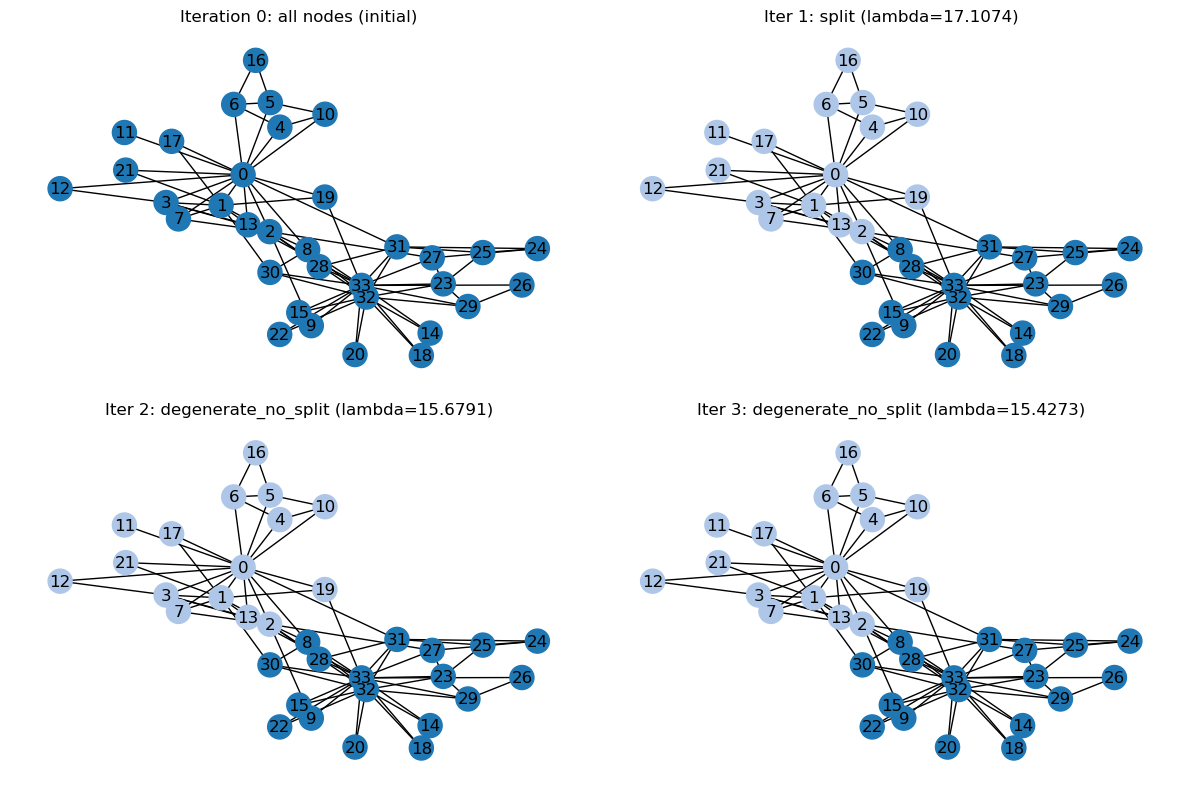

In [19]:
# Visualize initial + each iteration recorded in history
num_plots = len(history) + 1  # include initial baseline
cols = 2
rows = (num_plots + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

# Iteration 0 (initial)
draw_partition(G, [sorted(G.nodes())], fixed_pos, ax=axes[0], title='Iteration 0: all nodes (initial)')

# Replay history to reconstruct partitions step-by-step
for i, h in enumerate(history, start=1):
    # reconstruct partition up to this history entry
    comms = [sorted(G.nodes())]
    for hh in history[:i]:
        if hh['action'] == 'split':
            grp = sorted(hh['group'])
            for c in comms:
                if set(c) == set(grp):
                    comms.remove(c)
                    break
            comms.append(sorted(hh['plus']))
            comms.append(sorted(hh['minus']))
    title = f"Iter {i}: {h['action']} (lambda={h['lambda']:.4f})"
    ax = axes[i] if i < len(axes) else None
    draw_partition(G, comms, fixed_pos, ax=ax, title=title)

# Hide any unused axes
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Evolution of Centrality Metrics Across Splits

We now plot, for each metric:

- the value per node,
- tracked across iterations (x-axis).

These plots allow us to observe:
- which nodes consistently remain important,
- how splitting affects structural roles,
- which nodes act as “bridges” or “hubs”.


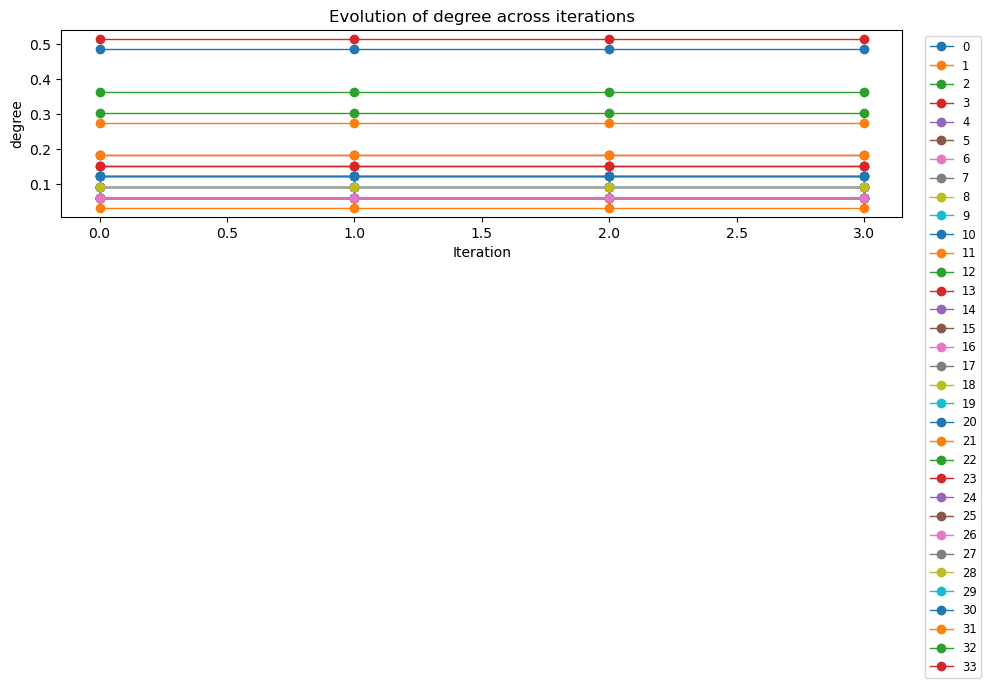

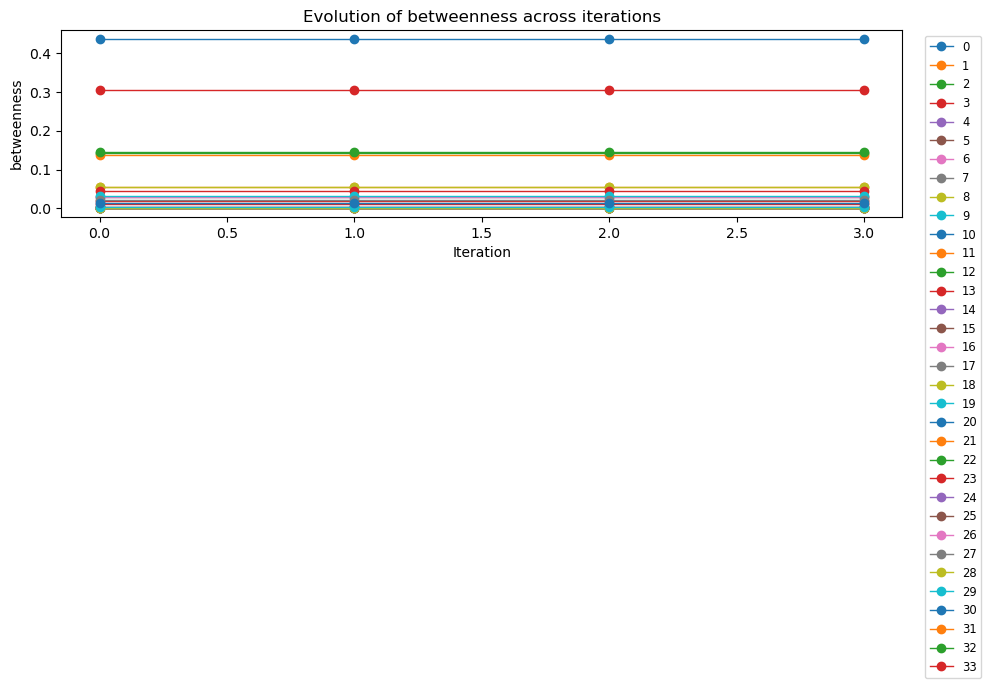

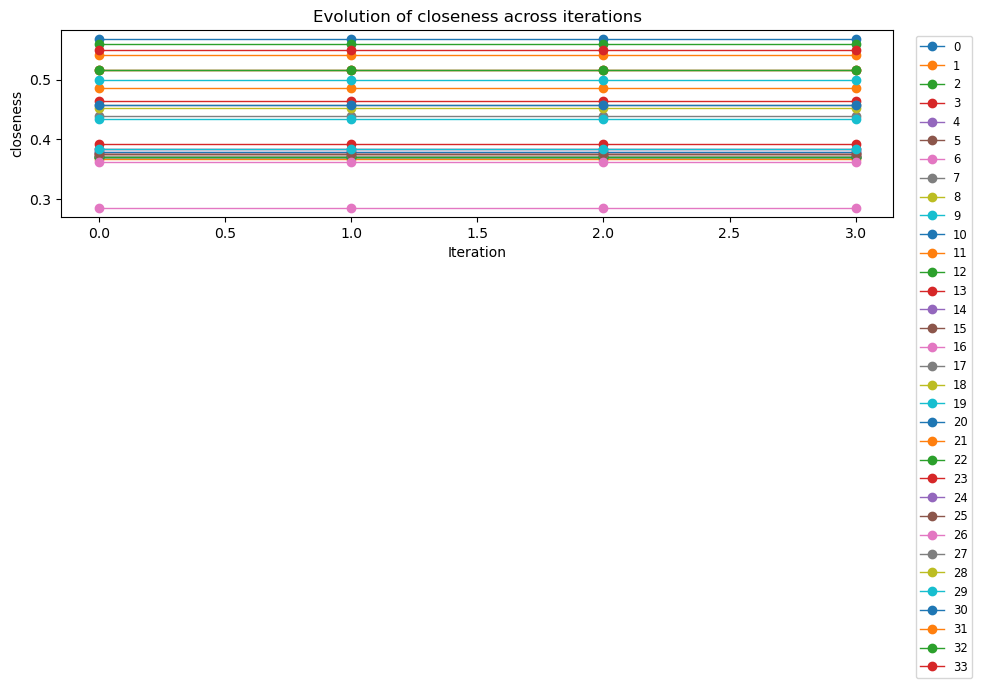

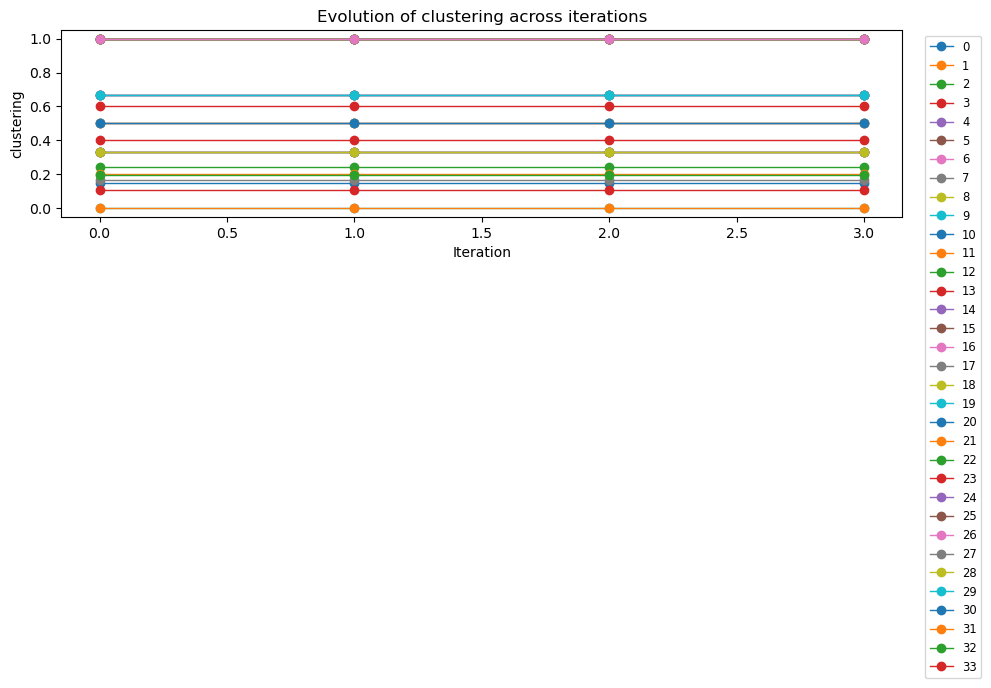

In [20]:
# Plot evolution for each metric: each node gets a line across iterations
iters = sorted(metrics_over_iters.keys())
nodes_sorted = sorted(G.nodes())

for metric_name in ['degree', 'betweenness', 'closeness', 'clustering']:
    plt.figure(figsize=(10,5))
    for node in nodes_sorted:
        values = [metrics_over_iters[it][metric_name][node] for it in iters]
        plt.plot(iters, values, marker='o', linewidth=1, label=str(node))
    plt.xlabel('Iteration')
    plt.ylabel(metric_name)
    plt.title(f'Evolution of {metric_name} across iterations')
    # legend may be busy; placed on the right
    plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', ncol=1, fontsize='small')
    plt.tight_layout()
    plt.show()
